In [1]:
import pandas as pd
import numpy as np
import requests
import os

from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

from utils.vocab import Vocabulary
from sklearn.cluster import KMeans
from joblib import load

from utils.plot_utils import plot_and_save_history
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Utils

In [2]:
class AutoEncoder(object):
    """ 4-layer LSTM Autoencoder
    Parameters
        vocab: Vocabulary object that stores char-to-int mappings 
            and text processing functions.
        hidden_size: Dimension of latent space between encoder and decoder.
            Default: 64.
        dropout: Fraction of units to be randomly ignored during training.
            Both linear and recurrent dropout are used.
            Default: 0.2.
    """
    DEFAULT_HIDDEN_UNITS = 64
    DEFAULT_DROPOUT = 0.2
    DEFAULT_BATCH_SIZE = 64
    DEFAULT_EPOCHS = 100
    DEFAULT_MODEL_WEIGHT_PATH = './models/autoencoder-weights.h5'
    model_name = 'autoencoder'

    def __init__(self, vocab, hidden_size=None, dropout=None):
        if not hidden_size:
            self.hidden_size = AutoEncoder.DEFAULT_HIDDEN_UNITS
        if not dropout:
            self.dropout = AutoEncoder.DEFAULT_DROPOUT
            
        self.vocab = vocab
        self.vocab_size = vocab.vocab_size
        self.max_input_seq_length = vocab.max_input_seq_length

        encoder_inputs = Input(shape=(None,), name='encoder_inputs')
        encoder_embedding = Embedding(input_dim=self.vocab_size,
                                      output_dim=self.hidden_size,
                                      input_length=self.max_input_seq_length,
                                      name='encoder_embedding')
        encoder_lstm = LSTM(units=self.hidden_size,
                            return_state=True,
                            dropout=self.dropout,
                            recurrent_dropout=self.dropout,
                            name='encoder_lstm')
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, self.vocab_size), name='decoder_inputs')
        decoder_lstm = LSTM(units=self.hidden_size, return_state=True,
                            return_sequences=True, name='decoder_lstm')
        decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
        decoder_dense = Dense(units=self.vocab_size, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        self.model = model

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(self.hidden_size,)), Input(shape=(self.hidden_size,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                                         initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs,
                                   [decoder_outputs] + decoder_states)

    def load_weights(self, weight_file_path):
        if os.path.exists(weight_file_path):
            self.model.load_weights(weight_file_path)

    def generate_batch(self, samples, batch_size):
        num_batches = len(samples) // batch_size
        while True:
            for batchIdx in range(0, num_batches):
                start = batchIdx * batch_size
                end = (batchIdx + 1) * batch_size
                encoder_input_data_batch = pad_sequences(samples[start:end], self.max_input_seq_length)
                decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_input_seq_length,
                                                            self.vocab_size))
                decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_input_seq_length,
                                                           self.vocab_size))
                for textIdx, chars in enumerate(samples[start:end]):
                    for idx, char in enumerate(chars):
                        if char != 1: # not <UNK>
                            decoder_input_data_batch[textIdx, idx, char] = 1
                            if idx > 0:
                                decoder_target_data_batch[textIdx, idx - 1, char] = 1
                yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

    def fit(self, Xtrain, Xtest, epochs=None, batch_size=None, weight_file_path=None):
        """
        Train model.
        Parameters:
            Xtrain: Array of strings for training.
            Xtest: Array of strings for validation.
            epochs: Number of full forward passes of all training samples.
                Default: 50.
            batch_size: Number of samples to pass for one iteration.
                Default: 64.
            weight_file_path: File path with extension '.h5'
                for saving weights of the network. (https://www.h5py.org/)
                Default: ./models/autoencoder-weights.h5
        """

        if not epochs:
            epochs = AutoEncoder.DEFAULT_EPOCHS
        if not batch_size:
            batch_size = AutoEncoder.DEFAULT_BATCH_SIZE
        if not weight_file_path:
            weight_file_path = AutoEncoder.DEFAULT_WEIGHT_FILE_PATH

        checkpoint = ModelCheckpoint(weight_file_path)

        Xtrain = self.vocab.transform_texts(Xtrain)
        Xtest = self.vocab.transform_texts(Xtest)

        train_gen = self.generate_batch(Xtrain, batch_size)
        test_gen = self.generate_batch(Xtest, batch_size)

        train_num_batches = len(Xtrain) // batch_size
        test_num_batches = len(Xtest) // batch_size

        history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                           epochs=epochs, verbose=True,
                                           validation_data=test_gen, validation_steps=test_num_batches,
                                           callbacks=[checkpoint])
        self.model.save_weights(weight_file_path)
        return history

    def predict(self, input_text):
        """
        Process input texts and reconstruct them.
        Used to check how well model "understands" input texts.
        Parameters:
             input_text: 
        """
        input_seq = self.vocab.transform_texts([input_text])
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.vocab_size))
        target_seq[0, 0, self.vocab.char2idx['<START>']] = 1
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_char = self.vocab.idx2char[sample_token_idx]
            target_text_len += 1

            if sample_char != '<START>' and sample_char != '<END>':
                target_text += ' ' + sample_char

            if sample_char == '<END>' or target_text_len >= self.max_input_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, self.vocab_size))
            target_seq[0, 0, sample_token_idx] = 1

            states_value = [h, c]
        return target_text.strip()

In [3]:
def get_features(vectors):
    # vector: string -> vector_embedding: [char_indices]
    # [char_indices] are padded with 0 to the right
    vector_embedding = vocab.transform_texts([vector])
    
    # vector_embedding: [char_indices] -> encoders_states: [state_h, state_c]
    encoder_states = encoder.predict([vector_embedding])
    
    # use state_h as feature
    vector_features = encoder_states[0]
    
    return vector_features

In [4]:
def predict_class(vector_features):
    vector_class = kmeans.predict(vector_features)[0]
    # "0"-class is invalid
    if vector_class == 0:
        vector_class = 25
    return vector_class

## Prediction

### Load data

In [15]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
data = pd.read_csv('../data/wallarm.csv', encoding='utf-8', lineterminator='\n')
data = data.fillna('<BLANK>')

### Load autoencoder

In [5]:
from keras import backend as K

K.set_learning_phase(0) #set testing phase

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = ''

In [11]:
vocab = Vocabulary()
vocab.vocab_file = './vocab-wallarm.json'
vocab.make_vocab(data['text'])
autoencoder = AutoEncoder(vocab)
autoencoder.load_weights('./models/train-wallarm.h5')
encoder = autoencoder.encoder_model

In [12]:
vector_embeddings = vocab.transform_texts(data['text'])
encoder_states = encoder.predict(vector_embeddings)
vector_features = encoder_states[0]

## Predict for 2 classes

In [49]:
n_clusters = 2

In [13]:
kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
labels = kmeans.fit_predict(vector_features)
result = pd.DataFrame(data)
result['class'] = labels

### Содержимое кластеров

In [16]:
result[result['class'] == 0]

,id,text,injection,class
9,42354,/handler_sync_example.example?i=j4sR/mhZpekzcpKcC5cUoFHo5e42TQeA6YzVZuR3mhhuaivOgsA/oncCkpo=,False,0
15,16094,/handler_sync_example.example?i=Ypg//ONuVSKGXMnxmNJk8d6NQDTWwBs9OUBxw7FuiARcp4PPJBes4cIR26Q=,False,0
30,13209,/handler_sync_example.example?i=IGnn4yUfWDWRW/s5k7fOmWINPyP8/oNUNNFGK5I2sA6OhKUDrBWSc7RhuHo=,False,0
46,7454,/handler_sync_example.example?i=VQvhcUQNO7XuQhQ62IeRQqjZ5/tqxSG/oH5a+mqvhstbDM+OnGojZBVBmSY=,False,0
64,35367,/handler_sync_example.example?i=yzNCCLCgio1CL82qhqLM8Tc2Z9yJVjOkej5uS8cEVT7UCO171b/f+oNdlRs=,False,0
68,6038,/handler_sync_example.example?i=E/gKKLlL2y34fgQ//QxWAII8IkWTloNAbgGxT/GH7UGa/ondDniPFQaK6UY=,False,0
74,10575,/handler_sync_example.example?i=68etMNpQLLJhFNjeL7xstZI1s7VZLK3GAIOakNJ/nucFupTjbazHU+ONflA=,False,0
97,7168,/handler_sync_example.example?i=d7Mau9dhQF8TG1R/OnfnvrKUSDcenjrAggRbD9WGWvry98QyzC4WZAusiEk=,False,0
108,1956,/handler_sync_example.example?i=eoB/y25gymKn+J/ZE7inLL/RGceV29iE6sw9tiDSJ44yGnVE6/OnpnYieV1=,False,0
109,1361,/handler_sync_example.example?i=YZrBVzimSaztRDWOLkRiaqu+T/oNuJgGJhLk5yvpg6dWfwjU1ugDXCoVQCk=,False,0


In [48]:
result[(result['class'] == 0) & result['injection'] == True]

,id,text,injection,class
253,99641,/example.example?Session=ZHAADI6G822ZU&View=List&ReturnJavaScript=9&FolderID=3&Sort=RevDate&Page...,True,0
3541,86081,/example.example?Session=LXOFIIGVFSY44&View=List&ReturnJavaScript=2&FolderID=44&Page=9&DoSearch=...,True,0
5295,86326,/example.example?Session=UMK15HV3HXIZO&View=List&ReturnJavaScript=7&FolderID=5&ContentType=javas...,True,0
5825,103803,/example.example?Session=LXOFIIGVFSY18&View=List&ReturnJavaScript=5&FolderID=1&Page=2&DoSearch=Y...,True,0
16879,95818,/example.example?Session=YHHD2QOGRFYZJ&View=List&ReturnJavaScript=3&FolderID=7&ContentType=javas...,True,0
23310,87726,/example.example?Session=UMK39HV5HXIZO&View=List&ReturnJavaScript=8&FolderID=22&Page=3&DoSearch=...,True,0
26059,85322,/example.example?Session=KDM5XQVLJMHQP&View=List&ReturnJavaScript=4&FolderID=7&ContentType=javas...,True,0
30884,85374,/example.example?Session=LXOFIIGVFSY25&View=List&ReturnJavaScript=1&FolderID=61&Page=6&DoSearch=...,True,0
31320,101100,/example.example?Session=UMK59HV3HXIZO&View=List&ReturnJavaScript=4&FolderID=38&Page=8&ContentTy...,True,0
31408,101015,/example.example?Session=MJ4RFI56HE9L1&View=DocumentList&ReturnJavaScript=7&FolderID=7&CurrentVi...,True,0


In [23]:
result[(result['class'] == 0)]['text'].apply(lambda x: x.startswith('/handler_sync_example')).value_counts()

True     7311
False      35
Name: text, dtype: int64

In [31]:
handler_sync = result[(result['class'] == 0)]
handler_sync['lol'] = handler_sync['text'].apply(lambda x: x.startswith('/handler_sync_example'))
handler_sync[handler_sync['lol'] == False]

/home/nene/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,text,injection,class,lol
253,99641,/example.example?Session=ZHAADI6G822ZU&View=List&ReturnJavaScript=9&FolderID=3&Sort=RevDate&Page...,True,0,False
2107,1454,/connectors/system/example.example?w=786&h=469&aoe=8&far=1&src=assets/images/books-new/javascrip...,False,0,False
3541,86081,/example.example?Session=LXOFIIGVFSY44&View=List&ReturnJavaScript=2&FolderID=44&Page=9&DoSearch=...,True,0,False
5295,86326,/example.example?Session=UMK15HV3HXIZO&View=List&ReturnJavaScript=7&FolderID=5&ContentType=javas...,True,0,False
5825,103803,/example.example?Session=LXOFIIGVFSY18&View=List&ReturnJavaScript=5&FolderID=1&Page=2&DoSearch=Y...,True,0,False
9585,27701,_gorilla_csrf=MTUyMzUyMDc6N2xJblZqVUd9NVIzQXdVRzFETDFaUmQxbHBZbmxxVGpkTk6EWjNLME6yTUhNNFdFUldURn...,False,0,False
13902,36961,_gorilla_csrf=MTUyMzA6NTA5NnxJbFo3WlRaelRXTnRSR4hNYmpkSUsxWkdZbTFDYlZoemFtaFlUR5BOTWs2SFlVbFpXbE...,False,0,False
16879,95818,/example.example?Session=YHHD2QOGRFYZJ&View=List&ReturnJavaScript=3&FolderID=7&ContentType=javas...,True,0,False
17626,14016,/handler_actor_example.example?token=by--2COXIy_c8lgfb7YBqiWs2Rn6evN1YRPZOydrXxs&stream=true&cou...,False,0,False
20250,41313,/example.example?Session=UMK81HV4HXIZO&View=List&ReturnJavaScript=Yes&RefreshFolderCounts=Yes&Co...,False,0,False


In [47]:
handler_sync[handler_sync['id'] == 7325]['text'].iloc[0]

'\r\n________________________________________\r\nОт: Осипова Анна\r\nОтправлено: 1 июля 6782 г. 5:78\r\nКому: Таращук Елана\r\nТема: Релизы\r\n\r\nПривет!\r\nНа той неделе подготовила два релиза, один – по итогам полугодия – конечно, занял очень много времени… Надеюсь, выхлоп будет хороший) Но по этому релизу у меня больше всего вопросов к цифрам...\r\n\r\n\r\n\r\n\r\n[/var/folders/np/pz_z7qz5438752bnw2q74wj64962gp/T/example.example.Word/WebArchiveCopyPasteTempFiles/example.example]\r\n\r\nАнна Осипова\r\nВедущий менеджер по маркетингу и связям с общественностью\r\nHeadHunter Урал\r\n\r\n+8 (745) 393-26-17  |  +9 (562) 433-22-81 |  example@example.example<mailto:example@example.example>\r\n\r\n\r\n'

In [24]:
result['text'].apply(lambda x: x.startswith('/handler_sync_example')).value_counts()

False    58543
True      7311
Name: text, dtype: int64

Видимо, в нулевом кластере собрались все запросы, начинающиеся с handler_sync
а также некоторые запросы, в которых часто потворяется слово example

### Однородность кластеров

In [54]:
cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
percentage = [x if x > 0.5 else 1 - x for x in percentage]
print(f'cluster sizes = {cluster_sizes}')
print(f'injection part sizes = {injection_part_sizes}')
print('cluster homogeneity =', [f'{perc:0.3}' for perc in percentage])

cluster sizes = [7346, 10161]
injection part sizes = [20, 3436]
cluster homogeneity = ['0.997', '0.662']


Так как первый кластер ушел под `handler_sync_example`, то второй кластер ничего не говорит о валидности данных. Соответственно, однородность близка к однородности датасета в целом, которая равна 50%. Засчет того, что кластер с `handler_sync_example` содержит, в основном, валидные вектора, во втором кластере однородность чуть-чуть повысилась.

### Predict for 3 classes  

In [55]:
n_clusters = 3

In [56]:
kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
labels = kmeans.fit_predict(vector_features)
result = pd.DataFrame(data)
result['class'] = labels

### Содержимое кластеров

In [61]:
result[result['class'] == 0]

,id,text,injection,class
9,42354,/handler_sync_example.example?i=j4sR/mhZpekzcpKcC5cUoFHo5e42TQeA6YzVZuR3mhhuaivOgsA/oncCkpo=,False,0
15,16094,/handler_sync_example.example?i=Ypg//ONuVSKGXMnxmNJk8d6NQDTWwBs9OUBxw7FuiARcp4PPJBes4cIR26Q=,False,0
30,13209,/handler_sync_example.example?i=IGnn4yUfWDWRW/s5k7fOmWINPyP8/oNUNNFGK5I2sA6OhKUDrBWSc7RhuHo=,False,0
36,92795,Category=%example.example%97;%19SID=%66697F4ED8E2CD9EEF6AC6B9E8DA22183B%46;%53PSID=%35499A1C3A37...,True,0
46,7454,/handler_sync_example.example?i=VQvhcUQNO7XuQhQ62IeRQqjZ5/tqxSG/oH5a+mqvhstbDM+OnGojZBVBmSY=,False,0
64,35367,/handler_sync_example.example?i=yzNCCLCgio1CL82qhqLM8Tc2Z9yJVjOkej5uS8cEVT7UCO171b/f+oNdlRs=,False,0
68,6038,/handler_sync_example.example?i=E/gKKLlL2y34fgQ//QxWAII8IkWTloNAbgGxT/GH7UGa/ondDniPFQaK6UY=,False,0
74,10575,/handler_sync_example.example?i=68etMNpQLLJhFNjeL7xstZI1s7VZLK3GAIOakNJ/nucFupTjbazHU+ONflA=,False,0
97,7168,/handler_sync_example.example?i=d7Mau9dhQF8TG1R/OnfnvrKUSDcenjrAggRbD9WGWvry98QyzC4WZAusiEk=,False,0
108,1956,/handler_sync_example.example?i=eoB/y25gymKn+J/ZE7inLL/RGceV29iE6sw9tiDSJ44yGnVE6/OnpnYieV1=,False,0


In [59]:
result[result['class'] == 1]

,id,text,injection,class
3,28821,D8j+oNbylTIGw=,False,1
5,74446,""" union/*M!719 */",True,1
8,76096,""" /*M!union*/",True,1
11,33516,kEC+oNOwUkgJOk4bn7Jm9wOWOT6V ... f9g=,False,1
17,76039,' union/*M!*/,True,1
18,43379,m¤ ..dEvÃ5,False,1
20,53171,%F3%3F%74%BF,False,1
27,81271,view' aNd '8'='6,True,1
29,53814,Sequoia F.3L Falco,False,1
32,56144,941 or/**/tvguaf()=768,True,1


In [60]:
result[result['class'] == 2]

,id,text,injection,class
0,59290,' and/**/38>( select\t(622)/**/from/*362 emhgpv gpnqdn odpxkn qgnoyb */htipaw),True,2
1,54992,"shqpkt"" union /*!426 all\t*/(select kwicwt(\t(\tyaaoda\t()), (236), (konjlq()), 619, nyknas ())...",True,2
2,64287,"nhnqag"" uniondistinct--154 298 plhlre exaloq unyote \r(select (rpfeir#15 256 15 rttlat 66 gsjxjq...",True,2
4,27825,"ened \"">\n <head>\n <script data-react-helmet=\""true\"" type=\""text/javascript\"">(function(w....",False,2
6,71873,"194 union#93 yguxsk 669 393 \r\tselect\t\texlgjh(), cirwsi((\t616), (#\r'qbtidf'), (#\r'xhqujm')...",True,2
7,87153,/example.example?%7Cmeta%82http-equiv=Set-Cookie%59content=%11testizfx=5232%28%6E,True,2
10,41055,/search?string=EPSON EXPRESSION HOME XP-794&rootCategory=&sort=1,False,2
12,101157,%24%3E%7Cscript%3Ealert(%12sap_its_urlmime_example.example%45)%4C/script%5E%1Cimg%78src=%33,True,2
13,74110,"794 and bjwdqp((318), \t/*M!354 932, (625),*/ (275), (91), 365, (22))=672",True,2
14,44176,https://example.example.ru/krasota/massage/?seamless=7&tabName=ORDER#,False,2


In [64]:
cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
homogenity = [x if x > 0.5 else 1 - x for x in percentage]
print(f'cluster sizes = {cluster_sizes}')
print(f'injection part sizes = {injection_part_sizes}')
print('cluster homogeneity =', [f'{fraction:0.3}' for fraction in homogenity])

cluster sizes = [9785, 19043, 37026]
injection part sizes = [2412, 6976, 22967]
cluster homogeneity = ['0.754', '0.634', '0.62']


Схожие выводы: однородность близка к 50%

## Find best n_clusters

In [70]:
homogenities = {}
for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
    labels = kmeans.fit_predict(vector_features)
    result = pd.DataFrame(data)
    result['class'] = labels
    
    cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
    injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
    percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
    homogenity = [x if x > 0.5 else 1 - x for x in percentage]
    homogenity = [round(x, 3) for x in homogenity]
    
    homogenities[n_clusters] = homogenity
    print(f'{n_clusters} done')

2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done


In [73]:
import json
with open('./reports/homogenities-wallarm.json', 'w') as file:
    json.dump(homogenities, file, sort_keys=True)

In [74]:
homogenities

{2: [0.541, 0.626],
 3: [0.62, 0.754, 0.634],
 4: [0.641, 0.761, 0.69, 0.562],
 5: [0.641, 0.546, 0.66, 0.871, 0.997],
 6: [0.547, 0.663, 0.654, 0.997, 0.87, 0.618],
 7: [0.661, 0.865, 0.626, 0.997, 0.513, 0.616, 0.687],
 8: [0.617, 0.76, 0.708, 0.957, 0.666, 0.686, 0.777, 0.997],
 9: [0.685, 0.971, 0.62, 1.0, 0.741, 0.758, 0.529, 0.667, 0.865],
 10: [0.761, 0.763, 0.971, 0.621, 1.0, 0.51, 0.743, 0.667, 0.679, 0.977],
 11: [0.763,
  0.972,
  0.761,
  0.695,
  0.686,
  1.0,
  0.594,
  0.979,
  0.502,
  0.741,
  0.872],
 12: [0.671,
  0.591,
  1.0,
  0.978,
  0.805,
  0.586,
  0.572,
  0.926,
  0.76,
  0.868,
  0.965,
  0.694],
 13: [0.603,
  1.0,
  0.59,
  0.624,
  0.979,
  0.949,
  0.873,
  0.683,
  0.809,
  0.694,
  0.966,
  0.659,
  0.763],
 14: [0.585,
  0.999,
  0.66,
  0.63,
  0.629,
  1.0,
  0.695,
  0.966,
  0.928,
  0.742,
  0.686,
  0.951,
  0.804,
  0.869],
 15: [0.689,
  0.876,
  0.634,
  0.969,
  0.999,
  1.0,
  0.948,
  0.602,
  0.743,
  0.936,
  0.925,
  0.704,
  0.635,
 

### 18 looks good

In [98]:
n_clusters = 18
kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
labels = kmeans.fit_predict(vector_features)
result = pd.DataFrame(data)
result['class'] = labels

cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
homogenity = [x if x > 0.5 else 1 - x for x in percentage]
homogenity = [round(x, 3) for x in homogenity]

In [99]:
homogenity

[0.937,
 0.731,
 1.0,
 0.58,
 0.844,
 0.535,
 0.672,
 0.999,
 0.982,
 0.607,
 0.963,
 0.725,
 0.856,
 0.531,
 0.978,
 0.686,
 0.895,
 0.749]

In [100]:
result[result['class'] == 0]

,id,text,injection,class
29,53814,Sequoia F.3L Falco,False,0
35,8868,"rip curl""\t\ns",False,0
57,51863,Per Hansson,False,0
107,52514,Twentieth Century Typeface,False,0
119,51263,Atychia desmotoma,False,0
161,53745,Texas State Guard Maritime Regiment,False,0
187,7281,|cat /etc/passwd,False,0
198,76761,<username>' OR 6=2--,True,0
235,3394,Dolce And Gabbana (Дольче Габбана),False,0
248,6707,perfume that smells like alien (keyword),False,0


In [78]:
result[result['class'] == 2]

,id,text,injection,class
18,43379,m¤ ..dEvÃ5,False,2
20,53171,%F3%3F%74%BF,False,2
56,1909,)G](by!bvK,False,2
58,6247,"æB©""""Or1.A¶Ä",False,2
61,9509,DeLeTe#752,False,2
66,81866,1' aNd '%'=',True,2
72,16445,PEPH,False,2
155,34555,\t_<?Q(&,False,2
160,33145,8Ca%26href=%31 ... &wr_id=349,False,2
183,40171,Ci()){Ý ... |àð;ðð«,False,2


In [79]:
result[result['class'] == 6]

,id,text,injection,class
6,71873,"194 union#93 yguxsk 669 393 \r\tselect\t\texlgjh(), cirwsi((\t616), (#\r'qbtidf'), (#\r'xhqujm')...",True,6
13,74110,"794 and bjwdqp((318), \t/*M!354 932, (625),*/ (275), (91), 365, (22))=672",True,6
26,71720,"893 union--anynpq mrrllu 556 55 \rall/*annawe thlvue */(select /**/hbfscc#\r(), (\tebxtst(( vika...",True,6
33,57671,664 and 'esprrx'>exelbw#gahbcp 71 mvnfng lxdmep bovfon rwabxc \r(),True,6
84,68961,"38 union /*lkcflg */select inkqgn((--87 yhvguc utffjp pfflhx 965 \r'ngsubj'), yofbqc(), ""iyuokc""...",True,6
98,56903,"365 or/**/'sgdckt'<=kjuswe(#yyrlsa cdimyw \rylrriy(), 'lkheli', (898), 641, 'ovdjge', (#\rpxiwjr...",True,6
99,59278,"986 or""uwtdvs"">(--vpddmu 459 oajcnr 423 313 579 drokae \rselect wjptjl () from/*88 veovkx 12 mdo...",True,6
105,56722,"755 or\t561=kviktj( (efkyns()), ( ""lnthxf""), 'pstsgp')",True,6
121,64414,"568 union distinct--lacbnc dnhmkl \r select\t/*isftuh 72 */48, /*riqgnd 457 */67, (--klonxp 64 j...",True,6
131,62323,"747 /*M!and(\tselect (\t54), */(142), 922, (83), ( fpsrfk((\t966))), ruoccv()\tfrom tuojqi)<=653",True,6


In [80]:
result[result['class'] == 7]

,id,text,injection,class
36,92795,Category=%example.example%97;%19SID=%66697F4ED8E2CD9EEF6AC6B9E8DA22183B%46;%53PSID=%35499A1C3A37...,True,7
147,86204,Category=%example.example%78;%58SID=%39F5E9BF54A53D2B16BB1B6BE33C1961DA%96;%39PSID=%28FF8329635A...,True,7
188,95683,Category=%example.example%78;%62SID=%14F111A74D5BA1843E912353927BD45A16%52;%76PSID=%91844F39A67F...,True,7
228,88205,Category=%example.example%64;%63SID=%25D514A82DDB9119231BB87A48D4127F7A%12;%44PSID=%88CE9C225B5E...,True,7
258,104810,Category=%example.example%33;%73SID=%42467A22732583E841582CB49A8B964856%28;%17PSID=%7654A832DC16...,True,7
290,86772,Category=%example.example%73;%71SID=%54DD44782AA3CF197813546CF612848819%47;%25PSID=%37EC34291D55...,True,7
311,100488,Category=%example.example%93;%86SID=%46CBB75972BD2A877847A222C39F5E1EC7%66;%89PSID=%62A6B2D728FA...,True,7
332,90386,Category=%example.example%18;%44SID=%98297532AA1D52CB9B44D56D5D8CD6ED69%12;%61PSID=%176EB6ADA76B...,True,7
341,91826,Category=%example.example%64;%35SID=%2999DF8B62D6777595D47B3DE64E56DE3F%61;%24PSID=%894A278CC3EB...,True,7
344,98238,Category=%example.example%78;%66SID=%811C8BC6B5B18235A831BBC6DD9C78CAF2%46;%46PSID=%79685A542798...,True,7


In [81]:
result[result['class'] == 14]

,id,text,injection,class
22,94425,%5Ca%65HrEf=VbScRiPt:MsgBox(14527)%7E,True,14
37,93692,%4Ca%19HrEf=VbScRiPt:MsgBox(75523)%2E,True,14
42,93205,%52%9E%8Clink%58rel=prefetch%66href=79594%1E,True,14
44,94626,%78%4E%2Ca%88HrEf=VbScRiPt:MsgBox(85837)%5E,True,14
54,96686,%73%1E%1Clink%55rel=prefetch%69href=61666%8E,True,14
73,88020,/%6Cscript%6Exss%3C/script%example.example%43,True,14
100,104961,%55%5E%9Clink%38rel=prefetch%54href=23453%4E,True,14
132,102076,%3Cscript%1Ealert(9)%7C/script%4E,True,14
137,88957,%55%6E%3Clink%96rel=prefetch%17href=76613%3E,True,14
145,88730,%17%3E%7Clink%17rel=prefetch%94href=99991%1E,True,14


### Is it test data who is responsible for these trash clusters?

In [82]:
test_data

,id,text,injection
0,91055,Category=%example.example%26;%83SID=%2174413819BE952F12C71195F97FCFA472%19;%21PSID=%337C129B7CD9...,True
1,64089,"69 union select\t(""wkvtet"")--\rfrom example.example",True
2,17273,"""intranet"" and ""portal"" and ""software""",False
3,426,mqotVpPJ1pZ7yFGgaaIqBjGFKtHn+ehYg-Pg6ynSUmffN1aeTKQ-hfXEIcoOXLBQSiH98ORO+Uv1ZFZDuqjqC8DIYEAjVHO7...,False
4,81130,buy' aNd '2'='3,True
5,50258,Tylocephale gilmorei,False
6,82661,GA7.9.2572983955.5157267983'+(select load_file('\\\\example.example.net\\edp'))+',True
7,76155,62 /*!95 union*/,True
8,28064,cPB/onDSbo9olYKvJX2tTRtSs=,False
9,41454,=VY/oneDFfAz3lrAPG7Td4YV2JUo ... OY4=,False


In [83]:
test_embeddings = vocab.transform_texts(test_data['text'])
test_states = encoder.predict(test_embeddings)
test_features = test_states[0]

In [94]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
labels = kmeans.fit_predict(test_features)
result = pd.DataFrame(test_data)
result['class'] = labels

cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
homogenity = [x if x > 0.5 else 1 - x for x in percentage]
homogenity = [round(x, 3) for x in homogenity]
homogenity

[0.659, 0.636, 0.998, 0.677, 0.616, 0.737, 0.552, 0.975]

In [97]:
result[result['class'] == 7]

,id,text,injection,class
31,85716,%6Ca%27HrEf=VbScRiPt:MsgBox(87185)%8E,True,7
42,93925,%6Ca%18HrEf=VbScRiPt:MsgBox(93422)%3E,True,7
112,95550,%25%2E%9Clink%85rel=prefetch%97href=79947%3E,True,7
156,99920,%96%3E%3Clink%74rel=prefetch%32href=71332%2E,True,7
159,89828,%7Ca%81HrEf=VbScRiPt:MsgBox(84677)%6E,True,7
173,97571,wiki%8Ca%97HrEf=VbScRiPt:MsgBox(33227)%6E,True,7
180,100019,%55%1E%6Clink%58rel=prefetch%65href=25919%8E,True,7
240,104141,%48%3E%9Clink%79rel=prefetch%78href=13663%2E,True,7
252,98110,%17%6E%7Clink%32rel=prefetch%21href=14955%5E,True,7
259,89018,%68%9E%1Clink%41rel=prefetch%66href=67148%4E,True,7


## With clean data

In [110]:
data = pd.read_csv('../data/wallarm.csv', lineterminator='\n')

In [104]:
vector_embeddings = vocab.transform_texts(data['text'])
encoder_states = encoder.predict(vector_embeddings)
encoder_features = encoder_states[0]

In [105]:
n_clusters = 16
kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
labels = kmeans.fit_predict(encoder_features)
result = pd.DataFrame(data)
result['class'] = labels

cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
homogenity = [x if x > 0.5 else 1 - x for x in percentage]
homogenity = [round(x, 3) for x in homogenity]
homogenity

[0.507,
 0.977,
 0.726,
 0.664,
 0.938,
 0.536,
 0.531,
 0.894,
 0.568,
 0.976,
 0.598,
 0.797,
 0.696,
 0.938,
 0.73,
 0.891]

In [108]:
result[result['class'] == 15]

,Unnamed: 0,id,text,injection,class
11,11,74110,"794 and bjwdqp((318), \t/*M!354 932, (625),*/ (275), (91), 365, (22))=672",True,15
25,25,60015,755 union/*mgjrer qqypxc */distinct\tselectdpohuefrom\texample.example,True,15
80,80,70186,""" union/*M!848 select*/ (wjsqir(747, (rjljrk()), (skgjua\t()), \t922, (\t26), rveghn ())), (\...",True,15
93,93,56722,"755 or\t561=kviktj( (efkyns()), ( ""lnthxf""), 'pstsgp')",True,15
115,115,62323,"747 /*M!and(\tselect (\t54), */(142), 922, (83), ( fpsrfk((\t966))), ruoccv()\tfrom tuojqi)<=653",True,15
139,139,16320,"Ik zou graag de vervolgafspraken van mijn zwangerschap inplannen, tot nu toe is er nog de echo 6...",False,15
155,155,62568,"93 and(select\t(/*!928),*/ jxbaob, rhcwlg(), 335\tfrom\texample.example)>=13",True,15
181,181,73300,"719 andvhnxvs/*!223 ((*/\t23), 285, (rtspbi()), 216, jjhbkd (), (yaoquk()), vbpoha(), \trgjek...",True,15
235,235,27281,"[SGB] Need rule for button ""Delete"" for users in admin console",False,15
236,236,38648,IN (\r\n SELECT DIS ... d)\r\nWHERE\r\n --Ð²,False,15


### New autoencoder

In [111]:
vocab = Vocabulary()
vocab.vocab_file = './vocab-wallarm.json'
vocab.make_vocab(data['text'])
autoencoder = AutoEncoder(vocab)
autoencoder.load_weights('./models/train-modified-wallarm.h5')
encoder = autoencoder.encoder_model

In [112]:
vector_embeddings = vocab.transform_texts(data['text'])
encoder_states = encoder.predict(vector_embeddings)
encoder_features = encoder_states[0]

In [213]:
n_clusters = 44
kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
labels = kmeans.fit_predict(encoder_features)
result = pd.DataFrame(data)
result['class'] = labels

cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
homogeneity = [x if x > 0.5 else 1 - x for x in percentage]
homogeneity = {i: round(x, 3) for i, x in enumerate(homogeneity)}

In [ ]:
data_size = len(result)
fractions = [round(cluster_size / data_size, 3) for cluster_size in cluster_sizes]
weighted_homogeneity = [value * fraction for value, fraction in zip(homogeneity, fractions)]

In [216]:
mean = np.mean(weighted_homogeneity)
homogeneity

{0: 0.686,
 1: 0.583,
 2: 0.97,
 3: 0.664,
 4: 0.895,
 5: 0.862,
 6: 0.767,
 7: 0.989,
 8: 0.94,
 9: 0.985,
 10: 0.753,
 11: 1.0,
 12: 0.579,
 13: 0.649,
 14: 0.887,
 15: 0.618,
 16: 0.996,
 17: 0.586,
 18: 0.997,
 19: 0.975,
 20: 0.968,
 21: 0.727,
 22: 0.998,
 23: 0.836,
 24: 0.797,
 25: 0.671,
 26: 0.952,
 27: 0.561,
 28: 0.807,
 29: 0.558,
 30: 0.961,
 31: 0.946,
 32: 0.798,
 33: 1.0,
 34: 0.607,
 35: 0.53,
 36: 0.646,
 37: 0.95,
 38: 0.834,
 39: 0.562,
 40: 0.695,
 41: 0.737,
 42: 0.982,
 43: 0.727}

In [217]:
mean

0.4840227272727272

In [153]:
homogeneities = {}
for n_clusters in range(2, 50):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
    labels = kmeans.fit_predict(encoder_features)
    result = pd.DataFrame(data)
    result['class'] = labels

    cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
    injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
    percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
    homogeneity = [x if x > 0.5 else 1 - x for x in percentage]

    homogeneity = {i: round(x, 3) for i, x in enumerate(homogeneity)}
    mean = round(np.mean(list(homogeneity.values())), 3)
    
    homogeneities[n_clusters] = {'mean': mean, 'per-cluser': homogeneity}
    print(f'{n_clusters} done')

2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done


In [154]:
homogenities

{2: {'mean': 0.7605, 'per-cluser': {0: 0.966, 1: 0.555}},
 3: {'mean': 0.7063333333333333, 'per-cluser': {0: 0.615, 1: 0.966, 2: 0.538}},
 4: {'mean': 0.6639999999999999,
  'per-cluser': {0: 0.576, 1: 0.966, 2: 0.602, 3: 0.512}},
 5: {'mean': 0.6954,
  'per-cluser': {0: 0.606, 1: 0.622, 2: 0.967, 3: 0.568, 4: 0.714}},
 6: {'mean': 0.6243333333333333,
  'per-cluser': {0: 0.601, 1: 0.507, 2: 0.967, 3: 0.501, 4: 0.596, 5: 0.574}},
 7: {'mean': 0.6858571428571427,
  'per-cluser': {0: 0.593,
   1: 0.512,
   2: 0.571,
   3: 0.937,
   4: 0.985,
   5: 0.6,
   6: 0.603}},
 8: {'mean': 0.7345,
  'per-cluser': {0: 0.516,
   1: 0.507,
   2: 0.603,
   3: 0.984,
   4: 0.562,
   5: 0.997,
   6: 0.773,
   7: 0.934}},
 9: {'mean': 0.7215555555555556,
  'per-cluser': {0: 0.518,
   1: 0.56,
   2: 0.985,
   3: 0.622,
   4: 0.506,
   5: 0.997,
   6: 0.932,
   7: 0.603,
   8: 0.771}},
 10: {'mean': 0.7472,
  'per-cluser': {0: 0.931,
   1: 0.973,
   2: 0.772,
   3: 0.518,
   4: 0.602,
   5: 0.984,
   6: 0.70

In [173]:
homogeneity

{'mean': 0.798,
 'per-cluser': {0: 0.815,
  1: 0.799,
  2: 0.989,
  3: 0.563,
  4: 0.954,
  5: 0.638,
  6: 0.996,
  7: 0.996,
  8: 0.511,
  9: 0.601,
  10: 0.57,
  11: 0.725,
  12: 0.992,
  13: 0.879,
  14: 0.732,
  15: 1.0,
  16: 0.97,
  17: 0.771,
  18: 0.989,
  19: 0.901,
  20: 0.781,
  21: 0.803,
  22: 0.936,
  23: 0.538,
  24: 0.906,
  25: 0.848,
  26: 0.982,
  27: 0.972,
  28: 0.926,
  29: 0.926,
  30: 0.771,
  31: 0.95,
  32: 0.967,
  33: 0.776,
  34: 0.781,
  35: 0.887,
  36: 0.725,
  37: 0.62,
  38: 0.539,
  39: 0.948,
  40: 0.652,
  41: 0.56,
  42: 0.76,
  43: 0.724,
  44: 0.623,
  45: 0.709,
  46: 0.553,
  47: 0.998,
  48: 0.531}}

In [164]:
import json
with open('./reports/homogeneities-wallarm.json', 'w') as file:
    json.dump(homogeneities, file, sort_keys=True)

In [171]:
from sklearn.metrics import homogeneity_score
labels_true = [1 if x == True else 0 for x in result['injection']]
labels_pred = result['class']
homogeneity_score(labels_true, labels_pred)

0.38664111928782663

Плохая метрика)))

In [187]:
max_homogeneity = np.max([homogenity['mean'] for n_clusters, homogenity in homogenities.items()])

In [188]:
max_homogeneity

0.82

Соответствующий кластер - 44 разбиения

In [195]:
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
homogeneity_scores = [(n_clusters, homogenity['mean']) for n_clusters, homogenity in homogenities.items()]

In [ ]:
list(zip(*homogeneity_scores))

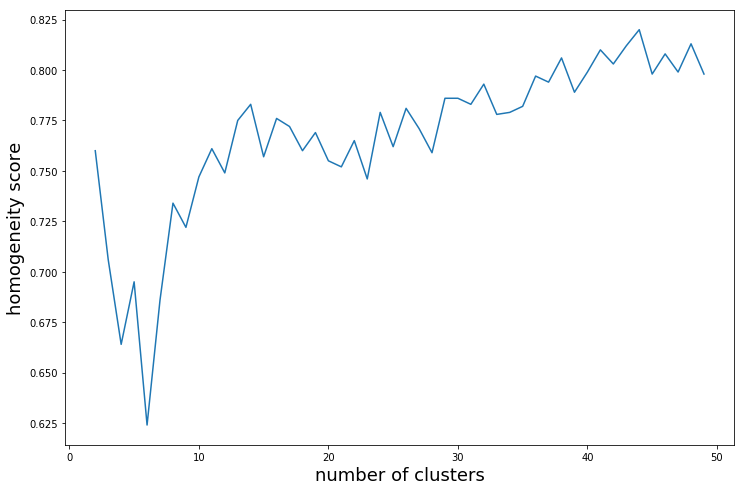

In [210]:
plt.figure(figsize=(12,8))
plt.xlabel('number of clusters', fontsize=18)
plt.ylabel('homogeneity score', fontsize=18)
plt.plot(*list(zip(*homogeneity_scores)))
plt.show()

In [218]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [219]:
tf_idf_features = TfidfVectorizer(analyzer='char').fit_transform(data['text'])

In [223]:
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, n_init=10, n_jobs=-1)
labels = kmeans.fit_predict(encoder_features)
result = pd.DataFrame(data)
result['class'] = labels

cluster_sizes = [len(result[result['class'] == x]) for x in range(n_clusters)]
injection_part_sizes = [len(result[(result['class'] == x) & (result['injection'] == True)]) for x in range(n_clusters)]
percentage = [injection_part_size / cluster_size for cluster_size, injection_part_size in zip(cluster_sizes, injection_part_sizes)]
homogeneity = [x if x > 0.5 else 1 - x for x in percentage]
homogeneity = {i: round(x, 3) for i, x in enumerate(homogeneity)}

In [224]:
homogeneity

{0: 0.567,
 1: 0.84,
 2: 0.969,
 3: 0.904,
 4: 0.996,
 5: 0.906,
 6: 0.825,
 7: 0.879,
 8: 0.997,
 9: 0.998,
 10: 0.975,
 11: 0.671,
 12: 0.849,
 13: 0.65,
 14: 0.933,
 15: 0.934,
 16: 0.943,
 17: 0.743,
 18: 0.819,
 19: 0.874,
 20: 0.577,
 21: 0.979,
 22: 0.878,
 23: 0.81,
 24: 0.546,
 25: 0.536,
 26: 0.989,
 27: 0.668,
 28: 0.587,
 29: 0.842,
 30: 0.536,
 31: 0.971,
 32: 0.945,
 33: 0.543,
 34: 0.949,
 35: 0.982,
 36: 0.754,
 37: 0.656,
 38: 0.562,
 39: 1.0,
 40: 0.989,
 41: 0.785,
 42: 0.859,
 43: 0.939,
 44: 0.705,
 45: 0.592,
 46: 0.728,
 47: 0.792,
 48: 0.705,
 49: 0.898}

In [225]:
mean = round(np.mean(list(homogeneity.values())), 3)
mean

0.811